In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Natural Language Processing with Disaster Tweets — Fast, Practically-focused Notebook

**Goal:** Provide a compact, runnable Jupyter notebook that alternates markdown and code cells (English). Focus on speed — quick EDA, a fast baseline (TF-IDF + Logistic Regression), and a lightweight deep model (Embedding + LSTM). This is intended to run quickly on Kaggle (use GPU if available).

---

In [2]:
## 1. Setup — install / import and quick config
# Code: imports and config
import os
import sys
import time
import gc
from pathlib import Path

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# sklearn for baseline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# tensorflow / keras for deep model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# fast deterministic-ish behavior
np.random.seed(42)
tf.random.set_seed(42)

# Kaggle dataset path
INPUT_DIR = '/kaggle/input/nlp-getting-started'
print('Input dir exists?', os.path.exists(INPUT_DIR))

# reduce TF logging
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


## 2. Load data and quick inspection
# Code: load csv files from Kaggle competition dataset
train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

print('train shape, test shape:', train.shape, test.shape)
train.head()

2025-09-22 00:57:33.802710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758502653.830795     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758502653.838939     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input dir exists? True
train shape, test shape: (7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


---

### Quick dataset description (markdown)

The `train.csv` contains columns: `id`, `text`, `location`, and `keyword` (some missing), and `target` (0 = not disaster, 1 = disaster). We'll focus on `text -> target`. For speed we won't use location/keyword features in the baseline, but you can add them later.

---

Target distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

Missing values per column:
id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64


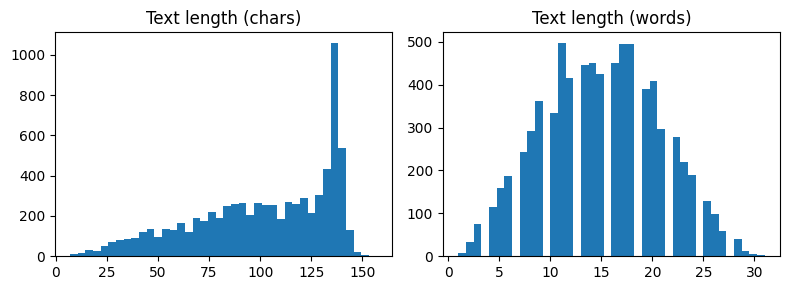

In [3]:
## 3. Fast EDA: class balance, text length distribution, missing values
# Code: EDA
print('Target distribution:')
print(train['target'].value_counts(normalize=True))

# Missing values
print('\nMissing values per column:')
print(train.isnull().mean())

# text length histogram (quick)
train['text_len'] = train['text'].str.len()
train['text_words'] = train['text'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(train['text_len'], bins=40)
plt.title('Text length (chars)')
plt.subplot(1,2,2)
plt.hist(train['text_words'], bins=40)
plt.title('Text length (words)')
plt.tight_layout()
plt.show()

---

**EDA summary (markdown):**

* Classes are moderately imbalanced — consider stratified splits.
* Many texts are short (<50 words), so small models work well and training is fast.
* `location` and `keyword` have missing values — optional to use later.

---

In [4]:
## 4. Minimal text cleaning (fast) — lowercase, remove URLs, mentions, punctuation except keeping basic tokens
# Code: fast cleaner
import re

def fast_clean(text):
    # lowercase
    text = str(text).lower()
    # remove urls
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # remove user mentions and hashtags sign only (keep the words)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', '', text)
    # remove special characters (keep letters/numbers and some punctuation)
    text = re.sub(r"[^a-z0-9\s\.\,\'\-]", ' ', text)
    # collapse spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# apply quickly (in-place)
train['clean_text'] = train['text'].map(fast_clean)
test['clean_text'] = test['text'].map(fast_clean)

train[['text','clean_text']].sample(5, random_state=42)


## 5. Baseline model: TF-IDF + Logistic Regression (fast to run)
# Code: baseline pipeline
X = train['clean_text']
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)

# TF-IDF vectorizer — limit features for speed
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print('TF-IDF shape:', X_train_tfidf.shape)

# Logistic regression (saga/lbfgs) with limited iterations for speed
lr = LogisticRegression(max_iter=400, C=1.0, solver='saga', n_jobs=-1, random_state=42)
start = time.time()
lr.fit(X_train_tfidf, y_train)
print('Train time (s):', time.time()-start)

# evaluate
y_pred = lr.predict(X_val_tfidf)
print('Accuracy:', accuracy_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))
print('\nClassification report:\n', classification_report(y_val, y_pred))

## 6. Make baseline predictions for test set and prepare submission (markdown + code)
# Code: baseline prediction and save
X_test_tfidf = vectorizer.transform(test['clean_text'])
probs = lr.predict_proba(X_test_tfidf)[:,1]
preds = (probs >= 0.5).astype(int)
submission['target'] = preds
submission.to_csv('submission_baseline.csv', index=False)
print('Saved submission_baseline.csv — ready to submit to Kaggle')

## 7. Faster deep model: Tokenizer + Embedding + Bidirectional LSTM (small) — tuned for speed
# Code: prepare sequences
MAX_WORDS = 15000  # vocabulary size — small for speed
MAX_LEN = 80       # sequence length — most tweets are short
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

X_seq = tokenizer.texts_to_sequences(train['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_pad, y, test_size=0.12, random_state=42, stratify=y)

print('Sequence shapes:', X_train_seq.shape, X_val_seq.shape)

# Code: build small Bi-LSTM model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Code: train with early stopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# a ModelCheckpoint would save to disk if desired

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=6,
    batch_size=128,
    callbacks=[es],
    verbose=2
)
# Code: evaluate LSTM
val_preds_prob = model.predict(X_val_seq, batch_size=256).ravel()
val_preds = (val_preds_prob >= 0.5).astype(int)
print('LSTM accuracy:', accuracy_score(y_val_seq, val_preds))
print('LSTM F1:', f1_score(y_val_seq, val_preds))
print(classification_report(y_val_seq, val_preds))


## 8. LSTM — Test predictions and save submission

# Code: predict on test set
X_test_seq = tokenizer.texts_to_sequences(test['clean_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
probs_test = model.predict(X_test_pad, batch_size=256).ravel()
preds_test = (probs_test >= 0.5).astype(int)

submission_lstm = submission.copy()
submission_lstm['target'] = preds_test
submission_lstm.to_csv('submission_lstm.csv', index=False)
print('Saved submission_lstm.csv')

TF-IDF shape: (6699, 25000)
Train time (s): 0.07876801490783691
Accuracy: 0.8096280087527352
F1: 0.7576601671309192

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       521
           1       0.84      0.69      0.76       393

    accuracy                           0.81       914
   macro avg       0.82      0.80      0.80       914
weighted avg       0.81      0.81      0.81       914

Saved submission_baseline.csv — ready to submit to Kaggle
Sequence shapes: (6699, 80) (914, 80)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-22 00:57:43.665622: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
53/53 - 15s - 287ms/step - accuracy: 0.6499 - loss: 0.6249 - val_accuracy: 0.7571 - val_loss: 0.5668
Epoch 2/6
53/53 - 7s - 140ms/step - accuracy: 0.8439 - loss: 0.3727 - val_accuracy: 0.7987 - val_loss: 0.5226
Epoch 3/6
53/53 - 7s - 134ms/step - accuracy: 0.9158 - loss: 0.2239 - val_accuracy: 0.7757 - val_loss: 0.6839
Epoch 4/6
53/53 - 7s - 133ms/step - accuracy: 0.9457 - loss: 0.1555 - val_accuracy: 0.7604 - val_loss: 0.8168
Epoch 5/6
53/53 - 7s - 135ms/step - accuracy: 0.9481 - loss: 0.1503 - val_accuracy: 0.6991 - val_loss: 0.8127
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
LSTM accuracy: 0.7986870897155361
LSTM F1: 0.7472527472527472
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       521
           1       0.81      0.69      0.75       393

    accuracy                           0.80       914
   macro avg       0.80      0.79      0.79    

## 9. Quick hyperparameter ideas & speed tips (markdown)

* For quick iteration, use smaller vocab (`MAX_WORDS=10k-15k`) and short `MAX_LEN=60-100`.
* Use TF-IDF + linear models for leaderboard speed; deep models are slower.
* Use pretrained embeddings (GloVe) to improve accuracy — but loading large files costs time; use 50d or 100d for speed.
* Use mixed precision on GPU to speed training.

---

## 10. Conclusion (markdown)

* Baseline TF-IDF + LogisticRegression runs fast and typically gives strong baseline results for short texts.
* A small Bi-LSTM can improve recall for subtle cases but costs more time.
* Next steps: include `keyword` and `location` as features, perform targeted preprocessing (emoji handling, contractions), and try pretrained embeddings or transformer-based models (BERT) if resources allow.

---

## References (markdown)

* Kaggle competition page: "Natural Language Processing with Disaster Tweets"
* scikit-learn documentation: TF-IDF, LogisticRegression
* TensorFlow / Keras docs: Tokenizer, Embedding, LSTM

---

## Notes for Kaggle run (markdown)

* On Kaggle, enable GPU in Notebook Settings for faster LSTM training.
* Upload `submission_baseline.csv` or `submission_lstm.csv` to the competition page to get leaderboard rank and screenshot for Deliverable 3.

---

**End of notebook — run cells top-to-bottom on Kaggle.**